In [19]:
# importing required libraries
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

In [20]:
# Checking and creating a directory named 'data' if it doesn't already exist
if not os.path.exists('data'):
    os.mkdir('data')

In [21]:
# Defining a set of image transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean = 0.5,
        std = 0.5
    )
])

transform

Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)

In [22]:
%%capture

# Data preparation for training
fminst_data = torchvision.datasets.FashionMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transform
)

In [23]:
# Batch Size
batch_size = 16

# Initializes a DataLoader object to handle the FashionMNIST dataset
fmnist_dl = torch.utils.data.DataLoader(
    fminst_data,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True
)

fmnist_dl

In [24]:
# There are total 60000 training images , so by dividing 60k by batch size , length of dataloader is obtained i.e 60000/16=3750
print(len(fmnist_dl))

3750


In [25]:
# Creates an iterator from the DataLoader `fmnist_dl` which contains batches of data (images and labels).
dataiter = iter(fmnist_dl)

# Retrieves the next batch of images and labels from the iterator.
images, labels = next(dataiter)

print(images.shape, labels.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [26]:
classes = [
    't_shirt/top',
    'trouser',
    'pullover',
    'dress',
    'coat',
    'sandal',
    'shirt',
    'sneaker',
    'bag',
    'ankle_boots'
]

In [27]:
# This function display a grid of images in a single figure
def display_image_grid(epoch: int, step: int,  images: torch.Tensor, nrow: int):
    images = images / 2 + 0.5

    image_grid = make_grid(images, nrow)     # Images in a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel last
    image_grid = image_grid.cpu().numpy()    # To Numpy

    plt.imshow(image_grid)

    plt.xticks([])
    plt.yticks([])

    plt.show()
    plt.close()

# This function displays a single image
def display(img):
    img = img / 2 + 0.5

    img = img.permute(1, 2, 0)

    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

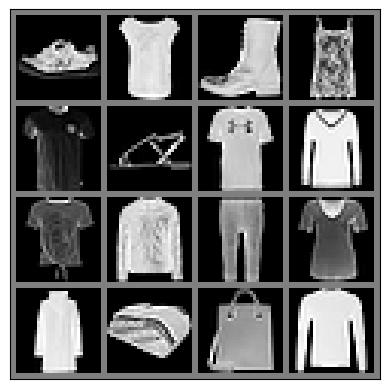

sneaker
 shirt
 ankle_boots
 shirt
 t_shirt/top
 sandal
 t_shirt/top
 pullover
 t_shirt/top
 coat 
 trouser
 t_shirt/top
 coat 
 bag  
 bag  
 pullover



In [28]:
display(make_grid(images, 4)) # show a grid of images

print(' '.join(f'{classes[labels[j]]:5s}\n' for j in range(16))) #printing the class labels

In [29]:
latent_size = 100
image_size = 784 # 28 x 28

In [30]:
# The generator, G, is designed to map the latent space vector (z) to data-space.
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

netG = Generator()
print(netG)

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [31]:
# The discriminator, is a binary classification network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

netD = Discriminator()
print(netD)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [32]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()
criterion

BCELoss()

In [33]:
# Creating instance of Generator class
netG = Generator()

# Creating instance of Discriminator class
nedD = Discriminator()

# Learning Rate
lr = 0.0002

# Initializing Adam optimizer both network
d_optimizer = optim.Adam(netD.parameters(), lr = lr)
g_optimizer = optim.Adam(netG.parameters(), lr = lr)

In [34]:
real_label = 1.
fake_label = 0.

In [35]:
# If instead of displaying step wise results, we want to display average epoch wise losses and scores, we can store avg values in separate lists
avg_G_losses = []
avg_D_losses = []
avg_real_score_list = []
avg_fake_score_list = []

num_epochs = 30

fixed_noise = torch.randn(batch_size, 100)

netD.train()
netG.train()

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [36]:
for epoch in tqdm(range(num_epochs)):

    G_losses = []
    D_losses = []

    real_score_list=[]
    fake_score_list=[]

    for i, data in enumerate(fmnist_dl, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad() # Clear the gradients of the discriminator network.

        # Reshape the real images to match the expected input shape of the discriminator.
        real_images = data[0].reshape(batch_size, 1, 784)

        # Create a tensor of real labels with the same batch size as the real images.
        real_labels = torch.full((batch_size,), real_label, dtype = torch.float)

        # Pass the real images through the discriminator and flatten the output.
        output = netD(real_images).view(-1)

        # Compute the discriminator loss on real images.
        errD_real = criterion(output, real_labels)

        # Backpropagate the loss for real images.
        errD_real.backward()

        # Calculate the mean score of the discriminator on real images.
        D_x = output.mean().item()

        # Generate fake image batch with G
        noise = torch.randn(batch_size, 100)

        # Create random noise to input to the generator.
        noise = torch.randn(batch_size, 100)

        # Generate fake images using the generator.
        fake_images = netG(noise)

        # Create a tensor of fake labels with the same batch size as the fake images.
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)

        # Pass the fake images through the discriminator without calculating gradients for them.
        output = netD(fake_images.detach()).view(-1)

        # Compute the discriminator loss on fake images.
        errD_fake = criterion(output, fake_labels)

        # Backpropagate the loss for fake images.
        errD_fake.backward()

        # Calculate the mean score of the discriminator on fake images before updating the generator.
        D_G_z1 = output.mean().item()

        # Compute the total discriminator loss.
        errD = errD_real + errD_fake

        # Update the discriminator network parameters.
        d_optimizer.step()



        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad() # Clear the gradients of the generator network.

        # Pass the generated fake images through the discriminator.
        output = netD(fake_images).view(-1)

        # Compute the generator loss based on the discriminator’s output.
        errG = criterion(output, real_labels)

        # Backpropagate the generator loss.
        errG.backward()

        # Calculate the mean score of the discriminator on fake images after updating the generator.
        D_G_z2 = output.mean().item()

        # Update the generator network parameters.
        g_optimizer.step()

        # Print the loss statistics and generated images every 200 steps or at the end of training.
        # if (i % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(fmnist_dl) - 1)):
        if i == len(fmnist_dl) - 1:
            print(f"""Epoch {epoch+0:01}: |
                      Step: {i} |
                      D_real Loss: {errD_real:.3f} |
                      D_fake Loss: {errD_fake:.3f} |
                      D_total Loss: {errD:.3f} |
                      G_Loss: {errG:.3f} |
                      Real_score {D_x:.3f} |
                      Fake_score {D_G_z1:.3f} |
                      Fake_score_after_D_update: {D_G_z2:.3f}
            """)



            # View the output of the GAN every so often
            with torch.no_grad():
                fake_images = netG(fixed_noise).reshape(batch_size, 1, 28, 28).detach().cpu()
                display_image_grid(epoch, i, fake_images, nrow=8)

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        real_score_list.append(D_x)
        fake_score_list.append(D_G_z1)


    avg_G_losses.append(np.mean(G_losses))
    avg_D_losses.append(np.mean(D_losses))
    avg_real_score_list.append(np.mean(real_score_list))
    avg_fake_score_list.append(np.mean(fake_score_list))

  0%|          | 0/30 [00:52<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.plot(avg_G_losses, label = 'Generator loss', alpha = 0.5)
ax1.plot(avg_D_losses, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(avg_real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(avg_fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()